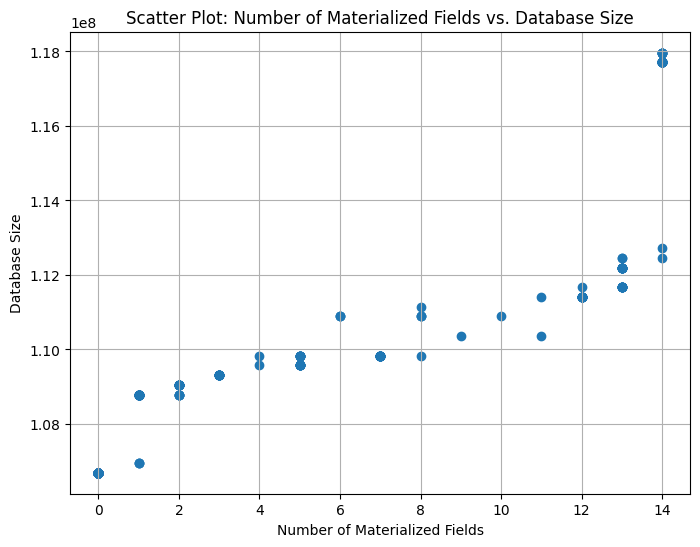

In [163]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Small dataset, 500 queries
RESULTS_PATH = "../results/tpch/2025-03-06-9H"
# Small dataset, 100 queries
# RESULTS_PATH = "../results/tpch/2025-03-10-14H"
# Small dataset, 500 queries (fewer param permutations)
# RESULTS_PATH = "../results/tpch/2025-03-05-15H"


# Read the CSV file
meta_results = pd.read_csv(RESULTS_PATH + "/meta_results.csv")

# Function to count the number of materialized fields from the string representation
def count_materialized_fields(s: str):
    try:
        # Converts the string representation to a python list
        fields = ast.literal_eval(s)
        return len(fields)
    except Exception as e:
        print(e)

# Create a new column with the number of materialized fields
meta_results["num_materialized_fields"] = meta_results["Materialization"].apply(count_materialized_fields)


# Exclude rows where Test is full_materialization
meta_results_no_full = meta_results[meta_results["Test"] != "full_materialization"]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(meta_results_no_full["num_materialized_fields"], meta_results_no_full["Database size"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Database Size")
plt.title("Scatter Plot: Number of Materialized Fields vs. Database Size")
plt.grid(True)
plt.show()


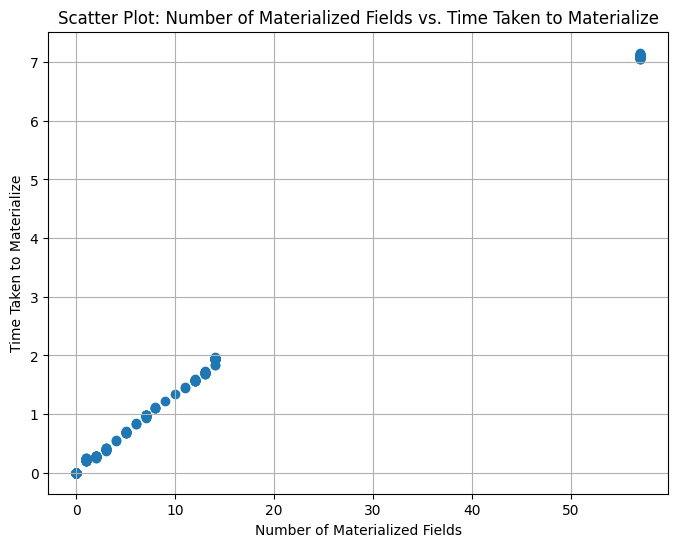

In [164]:
plt.figure(figsize=(8, 6))
plt.scatter(meta_results["num_materialized_fields"], meta_results["Time taken"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Time Taken to Materialize")
plt.title("Scatter Plot: Number of Materialized Fields vs. Time Taken to Materialize")
plt.grid(True)
plt.show()

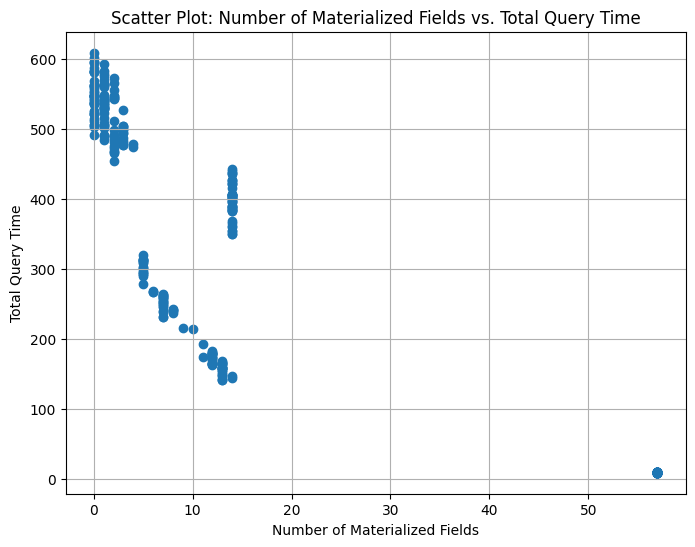

In [165]:
subset = meta_results[meta_results["Total query time"] > 0]
plt.figure(figsize=(8, 6))
plt.scatter(subset["num_materialized_fields"], subset["Total query time"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Total Query Time")
plt.title("Scatter Plot: Number of Materialized Fields vs. Total Query Time")
plt.grid(True)
plt.show()

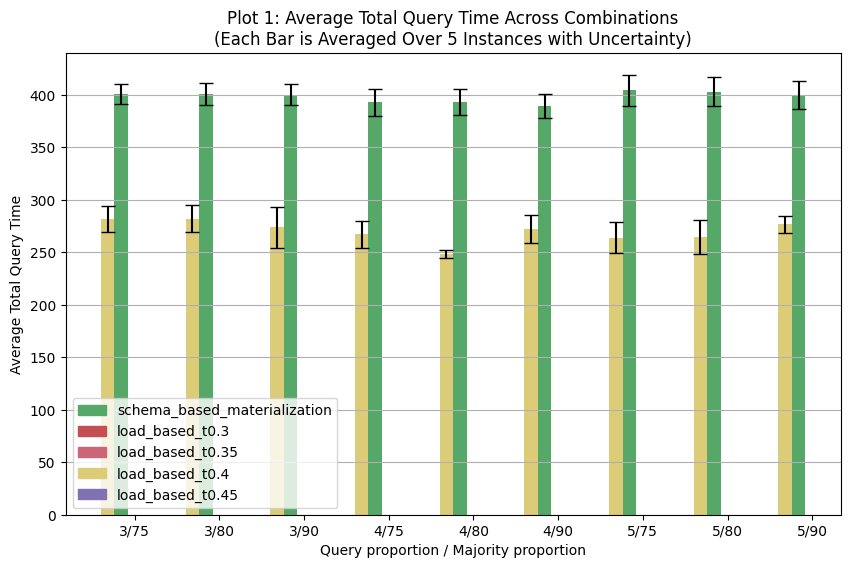

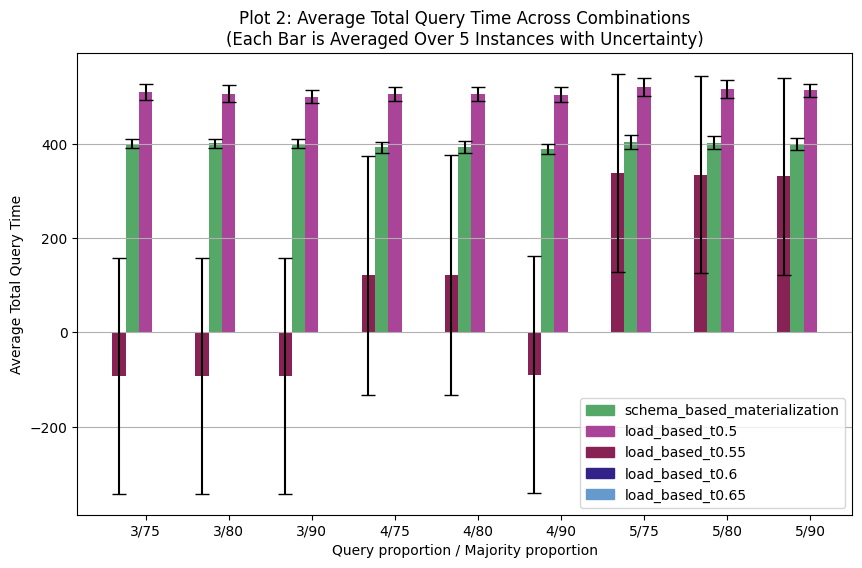

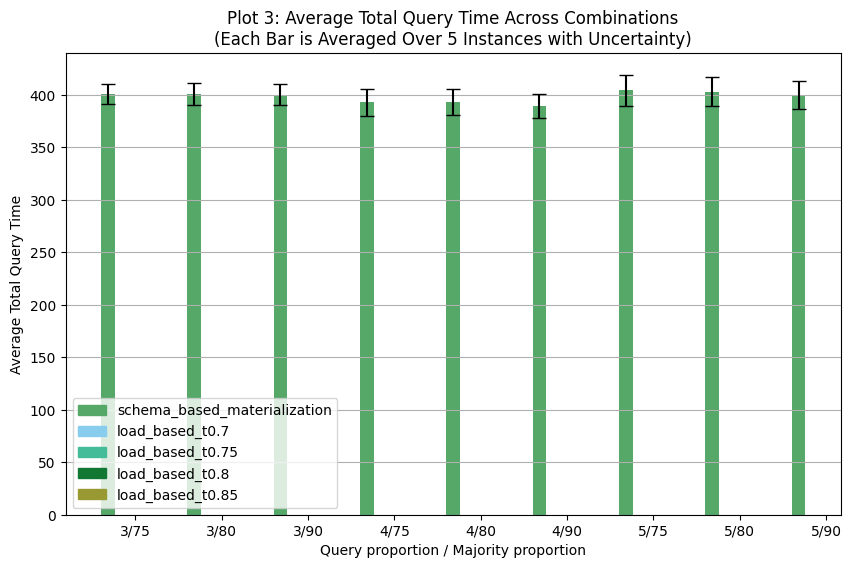

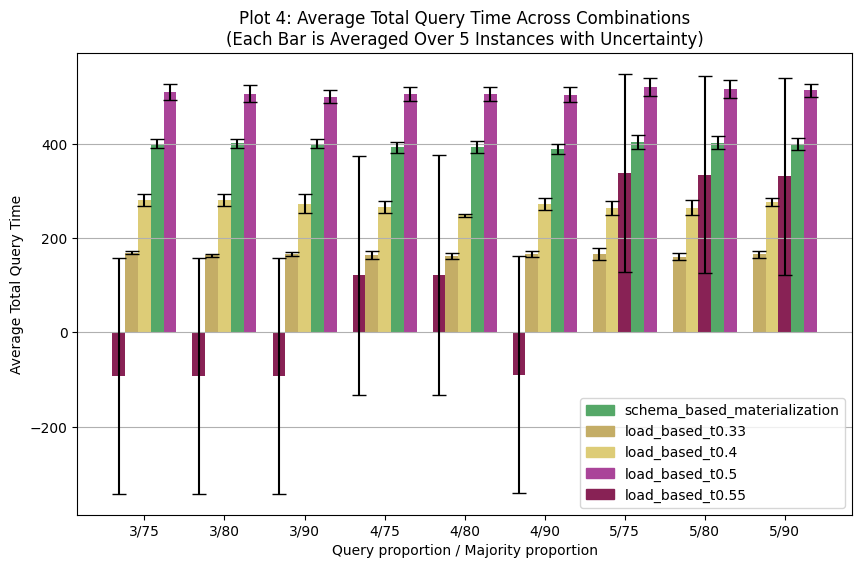

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Define color mapping for all tests (adjust the colors as needed)
colors = {
    "schema_based_materialization": "#55A868",  # muted green
    "load_based_t0.33": "#C4AD66",   # muted yellow
    "load_based_t0.3": "#C44E52",   # muted red
    "load_based_t0.35": "#CC6677",   # muted pinkish red
    "load_based_t0.4": "#DDCC77",   # muted yellow
    "load_based_t0.45": "#8172B3",   # muted purple
    "load_based_t0.5": "#AA4499",   # additional color
    "load_based_t0.55": "#882255",   # additional color
    "load_based_t0.6": "#332288",   # additional color
    "load_based_t0.65": "#6699CC",   # additional color
    "load_based_t0.7": "#88CCEE",   # additional color
    "load_based_t0.75": "#44BB99",   # additional color
    "load_based_t0.8": "#117733",   # additional color
    "load_based_t0.85": "#999933",   # additional color
}

# Define test groups for the three plots
plot_tests = {
    1: ["schema_based_materialization", "load_based_t0.3", "load_based_t0.35", "load_based_t0.4", "load_based_t0.45"],
    2: ["schema_based_materialization", "load_based_t0.5", "load_based_t0.55", "load_based_t0.6", "load_based_t0.65"],
    3: ["schema_based_materialization", "load_based_t0.7", "load_based_t0.75", "load_based_t0.8", "load_based_t0.85"],
    4: ["schema_based_materialization", "load_based_t0.33", "load_based_t0.4", "load_based_t0.5"],
}

# Loop over each plot group and generate a separate figure
for plot_num, tests in plot_tests.items():
    # Filter the DataFrame for the tests in the current group.
    df_current = meta_results[meta_results["Test"].isin(tests)].copy()
    
    # Create a new column for combination (Query proportion / Majority proportion)
    df_current["combination"] = df_current["Query proportion"].astype(str) + "/" + df_current["Majority proportion"].astype(str)
    
    # Group by combination and Test to compute mean, standard deviation, and count.
    grouped = df_current.groupby(["combination", "Test"])["Total query time"] \
                        .agg(mean="mean", std="std", count="count").reset_index()
    grouped["stderr"] = grouped["std"] / np.sqrt(grouped["count"])
    
    # Pivot the DataFrames for means and standard errors
    pivot_df = grouped.pivot(index="combination", columns="Test", values="mean").sort_index()
    stderr_df = grouped.pivot(index="combination", columns="Test", values="stderr").sort_index()
    
    # Create a new figure for the current plot
    fig, ax = plt.subplots(figsize=(10, 6))
    combinations_sorted = pivot_df.index.values
    x = np.arange(len(combinations_sorted))
    # Dynamically set bar width based on the number of tests in this group.
    bar_width = 0.8 / len(tests)
    
    # Loop over each combination and plot the bars with error bars.
    for i, comb in enumerate(combinations_sorted):
        # Get the data for the current combination (some tests might be missing).
        group_means = pivot_df.loc[comb].dropna()
        group_stderr = stderr_df.loc[comb].dropna()
        # Sort tests by average total query time (ascending)
        sorted_group = group_means.sort_values()
        sorted_stderr = group_stderr[sorted_group.index]
        # Plot each bar for the sorted tests
        for j, test in enumerate(sorted_group.index):
            ax.bar(x[i] + j * bar_width, sorted_group[test], bar_width, color=colors[test],
                   yerr=sorted_stderr[test], capsize=5)
    
    # Set x-tick labels centered under each combination group.
    ax.set_xticks(x + bar_width * (len(tests) - 1) / 2)
    ax.set_xticklabels(combinations_sorted)
    ax.set_xlabel("Query proportion / Majority proportion")
    ax.set_ylabel("Average Total Query Time")
    ax.set_title(f"Plot {plot_num}: Average Total Query Time Across Combinations\n(Each Bar is Averaged Over 5 Instances with Uncertainty)")
    ax.grid(True, axis='y')
    
    # Create a custom legend using the tests defined for this plot.
    legend_handles = [mpatches.Patch(color=colors[test], label=test) for test in tests]
    ax.legend(handles=legend_handles)
    
    plt.show()
